In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from wordcloud import WordCloud

%matplotlib inline


# Exploratory analysis of Swiss Products

In [2]:
swissDF  = pd.read_csv("Datasets/Swiss_reviews.csv")

In [3]:
def transformToList(x):
    newList=[]
    for i in range(1, len(x)):
        if i%2 != 0 :
            newList.append(x[i])
    return newList


def transformCategories(df):
    if 'Unnamed: 0' in df:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df[df.categories.notnull()]
    df['categories'] = df['categories'].apply(lambda x: x.split("'"))
    df['categories'] = df['categories'].apply(lambda x : transformToList(x))
    return df


swissDF = transformCategories(swissDF)

One of the first thing we'll need to do is transform the categories, which are a string right now, into a list of string.

In [4]:
swissDF.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,year,sentiment
0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9476
1,B000R9AAJA,"[1, 1]",5.0,These I bought for my co-worker who always bor...,"02 3, 2014",A034570920WVP7XFWHZ5I,Olyvia,Co-Worker is happy,1391385600,Logitech,"[Electronics, Computers & Accessories, Cables ...",2014,0.9755
2,B000R9AAJA,"[1, 1]",5.0,I bought these speakers for a friend's birthda...,"02 2, 2013",A100FXXJZMM6PI,Phillip Ly,Logitech S-120 Speakers,1359763200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8867
3,B000R9AAJA,"[1, 1]",5.0,My brother bought this speaker set for me back...,"10 20, 2012",A10636NGTJRUHN,sande276,Great!,1350691200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9463
4,B000R9AAJA,"[1, 1]",5.0,I have had these for a while and they work lik...,"01 31, 2013",A1071EF3JDBGI0,"R. Lorente ""Picky""",EXCELLENT!,1359590400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8528


We'll first look at the overall ratings, all categories mixed together

count    289878.000000
mean          4.195468
std           1.234766
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

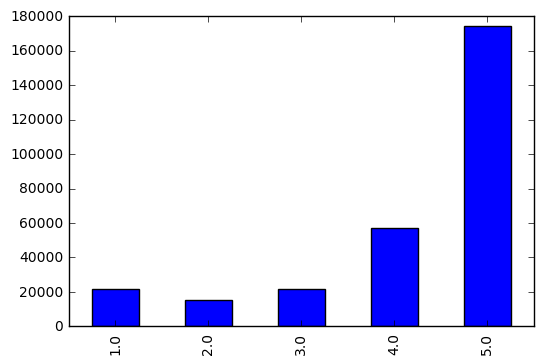

In [5]:
swissDF.overall.value_counts().sort_index().plot.bar()
swissDF.overall.describe()

The ratings are pretty high, but as we have determined before this is also the case for international products. So basing our observations on raw evaluations isn't enough, we'll try to separate them by categories and perform sentiment analysis

In [6]:
swissDF['year'] = swissDF['reviewTime'].astype(str)
swissDF['year'] = swissDF['year'].apply(lambda x: x[-4:])

In [7]:
yearGroup =swissDF.groupby(['year'])
yearGroup['overall'].agg(['count', 'mean'])

,count,mean
year,,
2000,12,4.416667
2001,49,3.918367
2002,70,3.942857
2003,205,4.136585
2004,307,3.491857
2005,826,3.984262
2006,1893,4.078711
2007,5514,4.273486
2008,7366,4.250068


The mean seems pretty consistent. with a few exceptions like 2004 which is probably due to a very inpopular product released back then. It also seems like the number of reviews is increasing exponentially.

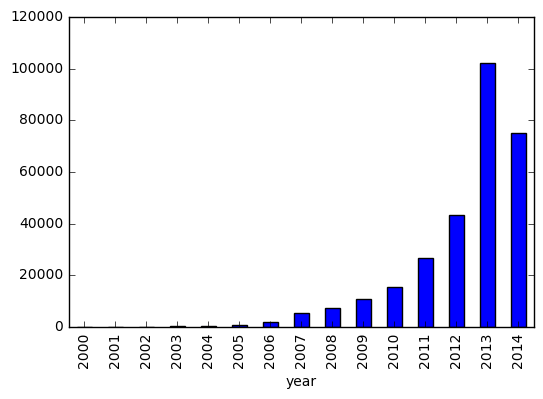

In [8]:
yearGroup['overall'].count().plot.bar()

2014 might seem smaller than 2013, but this data was collected in July 2014 which explains it.

We will now look at the dsitribution of reviews among swiss brands. Because some of them are much more popular than others (logitech being the most popular one) we will plot it using a logarithmic scale

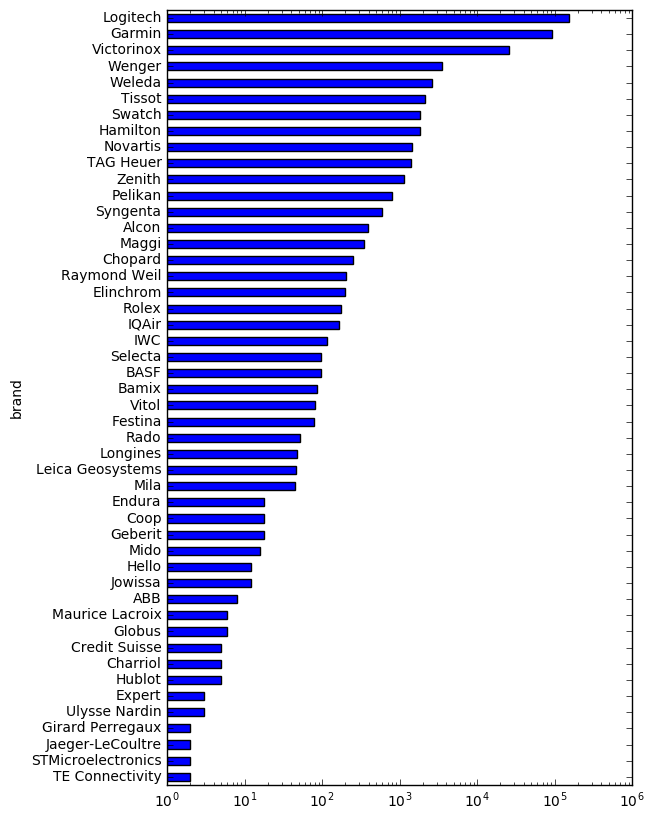

In [9]:
swissDF.groupby(['brand'])['brand'].count().sort_values(ascending=True).plot.barh(log=True, figsize=(6, 10))

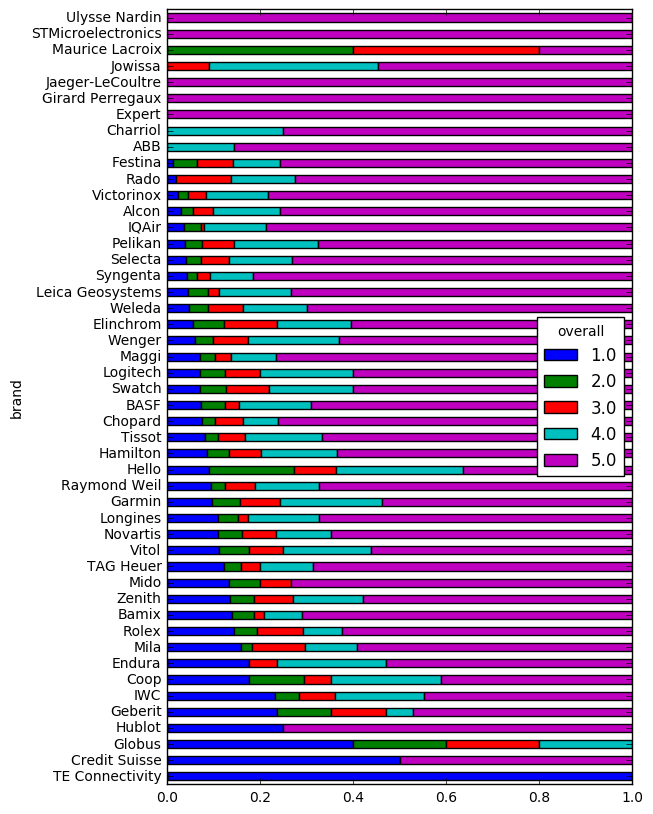

In [10]:
brandScore = swissDF.groupby(['brand', 'overall'])['brand']
brandScore = brandScore.count().unstack('overall')
brandScore.div(brandScore.sum(1), 0).sort_values(by=brandScore.keys()[0], ascending=False).plot(kind='barh', stacked=True, figsize=(6,10))
#problem here, the ratings are also put on a log scale so it seems like there are too many 1s. We could try to fix it or replace
#by piecharts

We will now group the reviews by category

In [11]:
categoriesCount = pd.DataFrame(swissDF['categories'].tolist()).stack().value_counts()
categoriesCount.head()

Electronics                  218203
Computers & Accessories      116378
Cables & Accessories          94113
GPS & Navigation              75883
Clothing, Shoes & Jewelry     45919
dtype: int64

Let's focus on the most reviewed categories

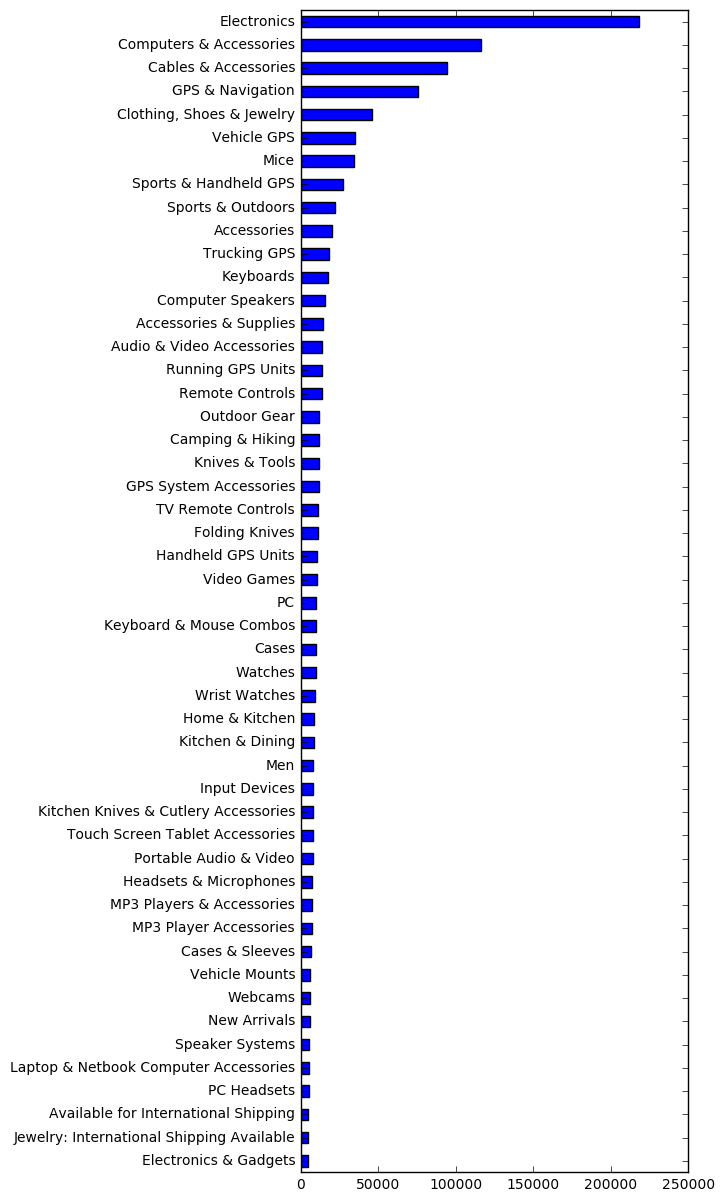

In [12]:
categoriesCount = categoriesCount.head(50)
categoriesCount.sort_values(inplace=False, ascending=True).plot.barh(figsize=(5,15))

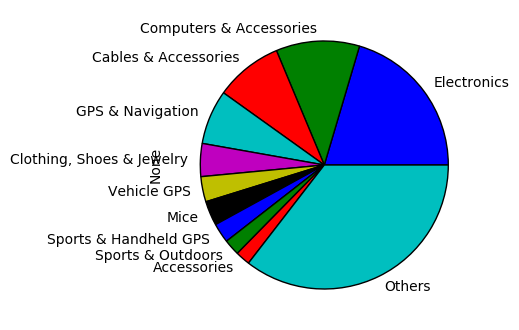

In [13]:
total = categoriesCount.sum()
top10 = categoriesCount.sort_values(ascending=False).head(10)
top10.loc['Others'] = total - top10.sum()
top10.plot.pie().set_aspect('equal')

We will now take a look at how well rated each of these categories are

In [14]:
categoriesCount.keys()

Index(['Electronics', 'Computers & Accessories', 'Cables & Accessories',
       'GPS & Navigation', 'Clothing, Shoes & Jewelry', 'Vehicle GPS', 'Mice',
       'Sports & Handheld GPS', 'Sports & Outdoors', 'Accessories',
       'Trucking GPS', 'Keyboards', 'Computer Speakers',
       'Accessories & Supplies', 'Audio & Video Accessories',
       'Running GPS Units', 'Remote Controls', 'Outdoor Gear',
       'Camping & Hiking', 'Knives & Tools', 'GPS System Accessories',
       'TV Remote Controls', 'Folding Knives', 'Handheld GPS Units',
       'Video Games', 'PC', 'Keyboard & Mouse Combos', 'Cases', 'Watches',
       'Wrist Watches', 'Home & Kitchen', 'Kitchen & Dining', 'Men',
       'Input Devices', 'Kitchen Knives & Cutlery Accessories',
       'Touch Screen Tablet Accessories', 'Portable Audio & Video',
       'Headsets & Microphones', 'MP3 Players & Accessories',
       'MP3 Player Accessories', 'Cases & Sleeves', 'Vehicle Mounts',
       'Webcams', 'New Arrivals', 'Speaker Systems

To find the entries that contain one category, the code to use looks like this

In [15]:
swissDF.categories.apply(lambda x: ' '.join(x)).str.contains('Electronics').head()

0    True
1    True
2    True
3    True
4    True
Name: categories, dtype: bool

In [16]:
flat = swissDF.categories.apply(lambda x: ' '.join(x)).str
res = categoriesCount.keys().to_series().map(lambda c: swissDF[flat.contains(c)].overall.mean())

In [17]:
res = res.reset_index(drop=False)

In [18]:
res.columns = ['category', 'mean of swiss products']

In [19]:
res = res.set_index(['category'])
res.head()

,mean of swiss products
category,
Electronics,4.151909
Computers & Accessories,4.237529
Cables & Accessories,4.240466
GPS & Navigation,4.077727
"Clothing, Shoes & Jewelry",4.236315


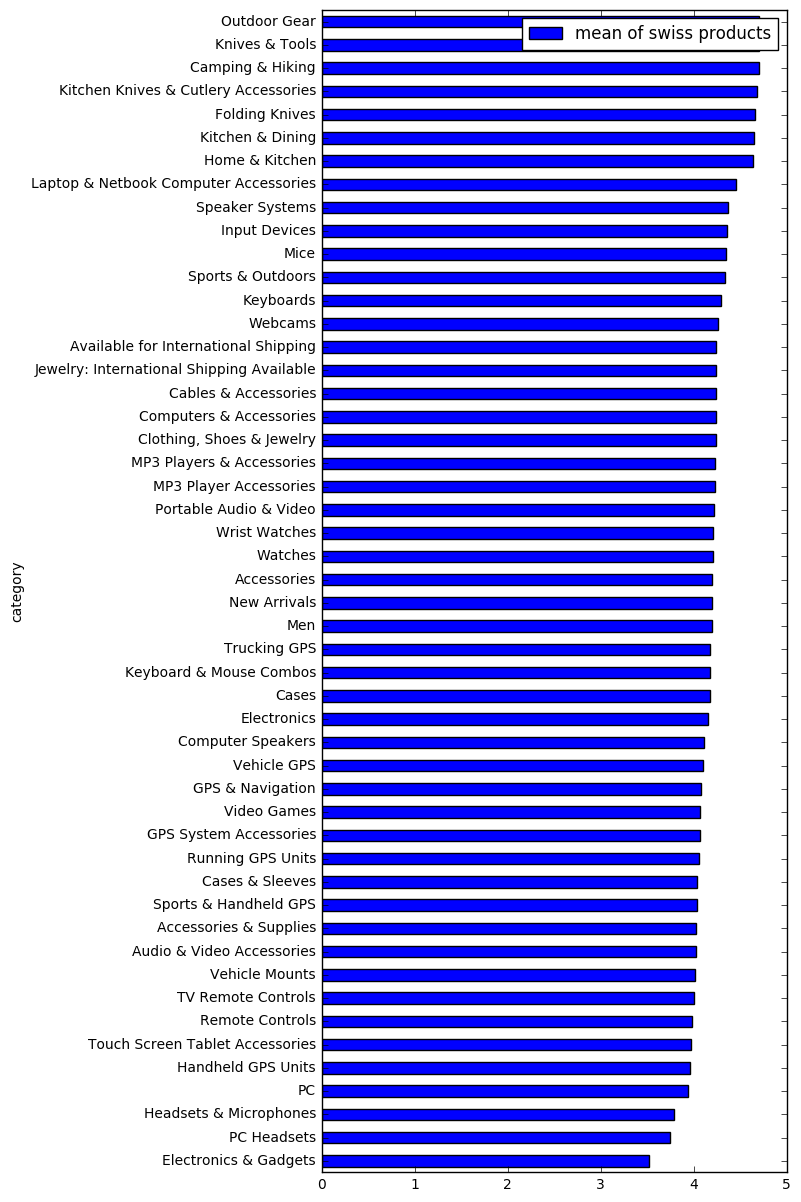

In [20]:
res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(6,15))
#TODO plot international products of same category on the side + maths on correlations

The last thing we need to check is to see what happens if we group the reviews first by product. This will show us if for example some very popluar results are skewing the means

In [21]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['overall'].agg(['count', 'mean']))
overallGrouped = productFrame['mean']

In [22]:
productFrame.count()

count    4718
mean     4718
dtype: int64

We can see that we have 4718 unique prodcuts in total. 
Now let's get the mean product wise

In [23]:
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

4.246266143689977
4.44117647059


Everything looks normal, which means that we have a relatively normal distrubtion of the reviews accros the products

In [24]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
brands = productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'])
brands

,count,mean,median
brand,,,
Ulysse Nardin,1,5.000000,5.000000
TE Connectivity,1,1.000000,1.000000
STMicroelectronics,1,5.000000,5.000000
Credit Suisse,1,3.000000,3.000000
Jaeger-LeCoultre,1,5.000000,5.000000
Girard Perregaux,1,5.000000,5.000000
Mila,2,4.146718,4.146718
IQAir,2,4.621212,4.621212
Expert,2,5.000000,5.000000


This is very nice view as it shows us which brands have the most products as well as the mean and the median review for each brand. 
In general we can say that most brands, especially the most popoluar ones, are very close to the general mean and distribtuion

/Users/bojan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


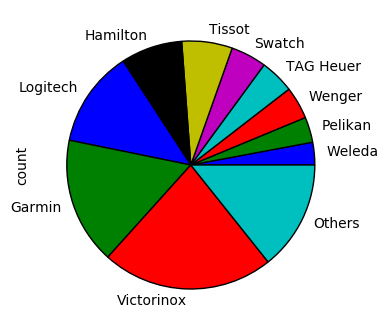

In [25]:
over100 = brands[brands['count'] > 100]['count']
over100.loc['Others'] = brands['count'].sum() - over100.sum()
over100.plot.pie().set_aspect('equal')

Brands repartition of swiss products on amazone.

In [26]:
import ast
helpful = []
for i in range(0, len(swissDF)):
    helpful.append(ast.literal_eval(swissDF['helpful'][i])[1] + 1)


In [27]:
swissDF['helpful'] = helpful
swissDF['coeff'] = swissDF['helpful'] * swissDF['overall']
productGroup = swissDF.groupby(['asin'])
productFrameWeighted = pd.DataFrame(productGroup['coeff'].agg(['count', 'sum']))
temp = pd.DataFrame(productGroup['helpful'].agg(['sum']))

In [28]:
productFrameWeighted['mean'] = productFrameWeighted['sum']/temp['sum']

In [29]:
print(np.mean(productFrameWeighted['mean']))
print(np.median(productFrameWeighted['mean']))

4.11279668207142
4.3307007176


# TEXT ANALYSIS

Now that we have finished working with the numerical ratings, we'll try to look for differences between Swiss and international products by basing our analysis on text.
First we'll start with the "summary" column

In [30]:
from nltk.sentiment.vader import *

In [31]:
stopwords = pd.read_csv('Datasets/stopwords_en.csv')

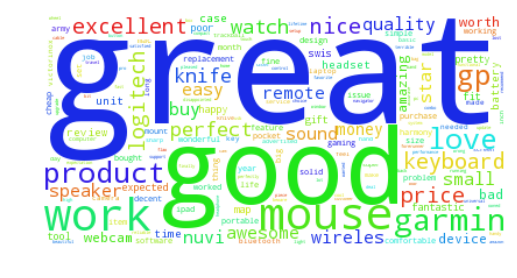

In [32]:
summaryBody = swissDF['summary'].apply(lambda x: x.lower())
textArray = summaryBody.values.flatten()
textString = ' '.join(textArray)
cloud = WordCloud(background_color="white", stopwords=stopwords).generate(textString)
plt.imshow(cloud)
plt.axis('off')
plt.show()

The code below was run to execute the sentiment analysis of the reviews, we have now commented it because the result was added to the dataframe

In [33]:
#analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()

We will now perform sentiment analysis on the review text joined with the summary

In [34]:
#review_polarity = []
#for i in range (0, len(USDF['reviewText'])):
#    review_polarity.append(analyzer.polarity_scores(' '.join([str(USDF['reviewText'][i]), USDF['summary'][i]]))['compound'])
#    if i % 1000 == 0:
#        print(i)

In [35]:
#len(review_polarity)

In [36]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['sentiment'].agg(['count', 'mean']))

In [37]:
print("Mean of sentiment")
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

Mean of sentiment
0.6534338998560479
0.72615


In [38]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'], ascending=False)

,count,mean,median
brand,,,
Victorinox,1056,0.712119,0.779360
Garmin,780,0.501308,0.547487
Logitech,595,0.629216,0.688054
Hamilton,378,0.661859,0.794742
Tissot,311,0.712240,0.790889
Swatch,219,0.653385,0.731450
TAG Heuer,211,0.702715,0.774700
Wenger,199,0.665085,0.742008
Pelikan,156,0.706711,0.819700


In [39]:
np.corrcoef(swissDF['overall'], swissDF['sentiment'])

array([[ 1.        ,  0.55085136],
       [ 0.55085136,  1.        ]])

The correlation is 0.55, which indicates a moderatetly high correlation between the overall rating and the review

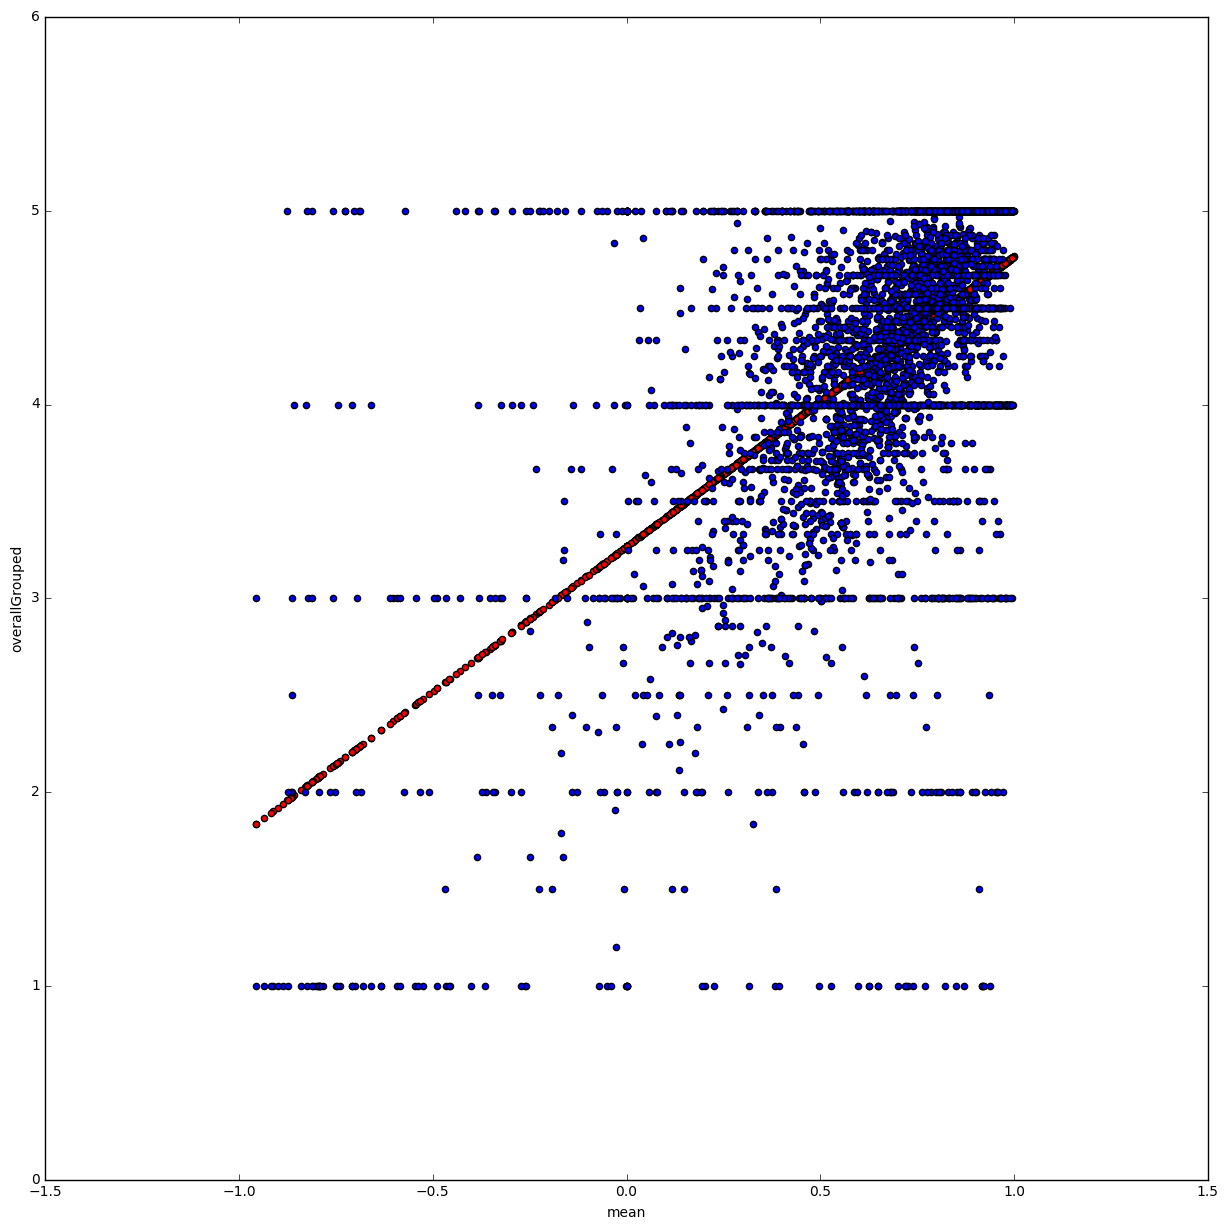

In [40]:
productFrame['overallGrouped'] = overallGrouped.tolist()
A = np.vstack([productFrame['mean'].tolist(),np.ones(len(productFrame['mean'].tolist()))]).T
xarr = np.array(productFrame['mean'].tolist())
m,c = np.linalg.lstsq(A,productFrame['overallGrouped'].tolist())[0]


productFrame['regression'] = (xarr*m + c)
ax = productFrame.plot.scatter(x='mean', y='regression', color="Red")
productFrame.plot.scatter(x='mean', y='overallGrouped' ,figsize=(15,15), ax=ax)

# Comparison of reviews

In [41]:
RandomDF = pd.read_csv("Datasets/RandomSample.csv")

count    298867.000000
mean          4.193016
std           1.230105
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

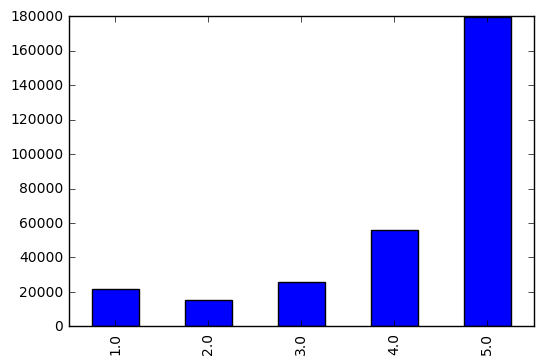

In [42]:
RandomDF.overall.value_counts().sort_index().plot.bar()
RandomDF.overall.describe()

In [43]:
scipy.stats.ttest_ind(swissDF['overall'],RandomDF['overall'], equal_var=False)

Ttest_indResult(statistic=0.76343203206340005, pvalue=0.44520608896728631)

In [44]:
scipy.stats.mannwhitneyu(swissDF['overall'],RandomDF['overall'], alternative='two-sided')

MannwhitneyuResult(statistic=43363427017.5, pvalue=0.42335681844284045)

In [45]:
GermanDF = pd.read_csv("Datasets/German_review.csv")

count    153843.000000
mean          4.155509
std           1.290023
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

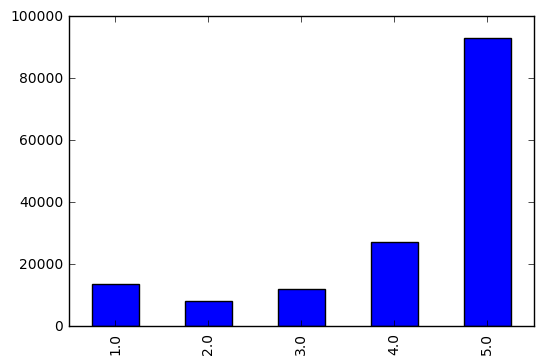

In [46]:
GermanDF.overall.value_counts().sort_index().plot.bar()
GermanDF.overall.describe()

In [47]:
scipy.stats.ttest_ind(swissDF['overall'],GermanDF['overall'], equal_var=False)

Ttest_indResult(statistic=9.965899286951716, pvalue=2.167175983670487e-23)

In [48]:
scipy.stats.mannwhitneyu(swissDF['overall'],GermanDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=22412633450.0, pvalue=0.001314498616021158)

In [49]:
scipy.stats.mannwhitneyu(swissDF['overall'],GermanDF[ 'overall'], alternative='greater')

MannwhitneyuResult(statistic=22412633450.0, pvalue=0.00065724930801057901)

In [50]:
USDF = pd.read_csv("Datasets/US_reviews.csv")

count    303939.000000
mean          4.099112
std           1.331076
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

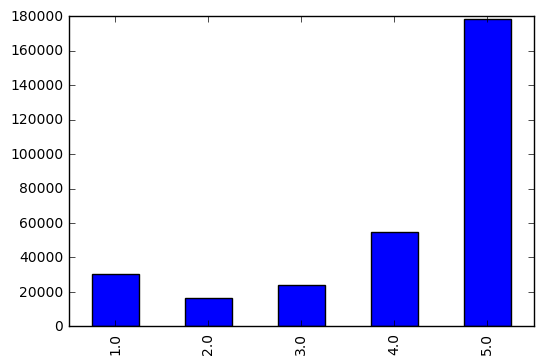

In [51]:
USDF.overall.value_counts().sort_index().plot.bar()
USDF.overall.describe()

In [52]:
scipy.stats.ttest_ind(swissDF['overall'],USDF['overall'], equal_var=False)

Ttest_indResult(statistic=28.935791963515495, pvalue=5.693712723251059e-184)

In [53]:
scipy.stats.mannwhitneyu(swissDF['overall'],USDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=45212122510.5, pvalue=1.2618068485557744e-87)

In [54]:
scipy.stats.mannwhitneyu(swissDF['overall'],USDF[ 'overall'], alternative='greater')

MannwhitneyuResult(statistic=45212122510.5, pvalue=6.3090342427788718e-88)

In [55]:
FrenchDF = pd.read_csv("Datasets/French_review.csv")

count    25642.000000
mean         4.126316
std          1.375260
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

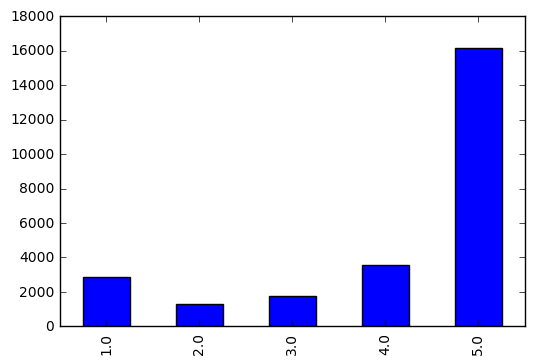

In [56]:
FrenchDF.overall.value_counts().sort_index().plot.bar()
FrenchDF.overall.describe()

In [57]:
scipy.stats.ttest_ind(swissDF['overall'],FrenchDF['overall'], equal_var=False)

Ttest_indResult(statistic=7.7792945240962261, pvalue=7.530944365807882e-15)

In [58]:
scipy.stats.mannwhitneyu(swissDF['overall'],FrenchDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=3688906157.0, pvalue=0.024588534203762509)

In [59]:
scipy.stats.mannwhitneyu(swissDF['overall'],FrenchDF[ 'overall'], alternative='less')

MannwhitneyuResult(statistic=3688906157.0, pvalue=0.012294267101881255)

# Comparison after grouping by product

In [60]:
def groupByProduct (DF):
    productGroup = DF.groupby(['asin'])
    productFrame = pd.DataFrame(productGroup['overall'].agg(['count', 'mean']))
    overallGrouped = productFrame['mean']
    return overallGrouped

In [61]:
groupByProduct(swissDF).describe()

count    4718.000000
mean        4.246266
std         0.811891
min         1.000000
25%         4.000000
50%         4.441176
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [62]:
groupByProduct(FrenchDF).describe()

count    2378.000000
mean        4.261580
std         0.941468
min         1.000000
25%         4.000000
50%         4.553288
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [63]:
groupByProduct(GermanDF).describe()

count    7930.000000
mean        4.217240
std         0.929429
min         1.000000
25%         4.000000
50%         4.500000
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [64]:
groupByProduct(USDF).describe()

count    11472.000000
mean         4.142353
std          0.966845
min          1.000000
25%          3.750000
50%          4.428571
75%          5.000000
max          5.000000
Name: mean, dtype: float64

In [65]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(FrenchDF))

Ks_2sampResult(statistic=0.11850166015948793, pvalue=7.8845266592152299e-20)

In [66]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(GermanDF))

Ks_2sampResult(statistic=0.057917492343721899, pvalue=4.401366952695648e-09)

In [67]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(USDF))

Ks_2sampResult(statistic=0.06025397258961937, pvalue=5.1786547394790326e-11)

In [68]:
scipy.stats.ttest_ind(groupByProduct(swissDF),groupByProduct(FrenchDF), equal_var=False)

Ttest_indResult(statistic=-0.67650379933529659, pvalue=0.49875812420643761)

In [69]:
scipy.stats.ttest_ind(groupByProduct(swissDF),groupByProduct(GermanDF), equal_var=False)

Ttest_indResult(statistic=1.8407472226250532, pvalue=0.065685595241250186)

In [70]:
scipy.stats.ttest_ind(groupByProduct(swissDF),groupByProduct(USDF), equal_var=False)

Ttest_indResult(statistic=6.9868650009140714, pvalue=2.983537901079814e-12)

# Comparison after grouping by product with weight

In [71]:
import ast
def groupByProductWeight (DF):   
    helpful = []
    for i in range(0, len(DF)):
        if type(DF['helpful'][i]) == np.int64:
            helpful.append(DF['helpful'][i])
        elif type(DF['helpful'][i]) == type([]):
            helpful.append(DF['helpful'][i][1] + 1)
        else:
            helpful.append(ast.literal_eval(DF['helpful'][i])[1] + 1)
    DF['helpful_count'] = helpful
    DF['coeff'] = DF['helpful_count'] * DF['overall']
    productGroup = DF.groupby(['asin'])
    productFrameWeighted = pd.DataFrame(productGroup['coeff'].agg(['count', 'sum']))
    temp = pd.DataFrame(productGroup['helpful_count'].agg(['sum']))
    productFrameWeighted['mean'] = productFrameWeighted['sum']/temp['sum']
    return productFrameWeighted['mean']

In [72]:
groupByProductWeight(swissDF).describe()

count    4718.000000
mean        4.112797
std         0.921279
min         1.000000
25%         3.629799
50%         4.330701
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [73]:
groupByProductWeight(GermanDF).describe()

count    7930.000000
mean        4.139842
std         0.995607
min         1.000000
25%         3.720451
50%         4.443376
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [74]:
groupByProductWeight(FrenchDF).describe()

count    2378.000000
mean        4.203848
std         1.005326
min         1.000000
25%         3.818080
50%         4.576037
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [75]:
groupByProductWeight(USDF).describe()

count    11472.000000
mean         4.057420
std          1.032248
min          1.000000
25%          3.535507
50%          4.333333
75%          5.000000
max          5.000000
Name: mean, dtype: float64

In [76]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(FrenchDF))

Ks_2sampResult(statistic=0.11850166015948793, pvalue=7.8845266592152299e-20)

In [77]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(GermanDF))

Ks_2sampResult(statistic=0.057917492343721899, pvalue=4.401366952695648e-09)

In [78]:
stats.ks_2samp(groupByProduct(swissDF), groupByProduct(USDF))

Ks_2sampResult(statistic=0.06025397258961937, pvalue=5.1786547394790326e-11)

# Comparison of sentiment data

# Comparison of category ratings

As a reminder, here are the ratings divided by the most popular categories of swiss products, we'll now add the ratings of those same categories for products that come from other countries

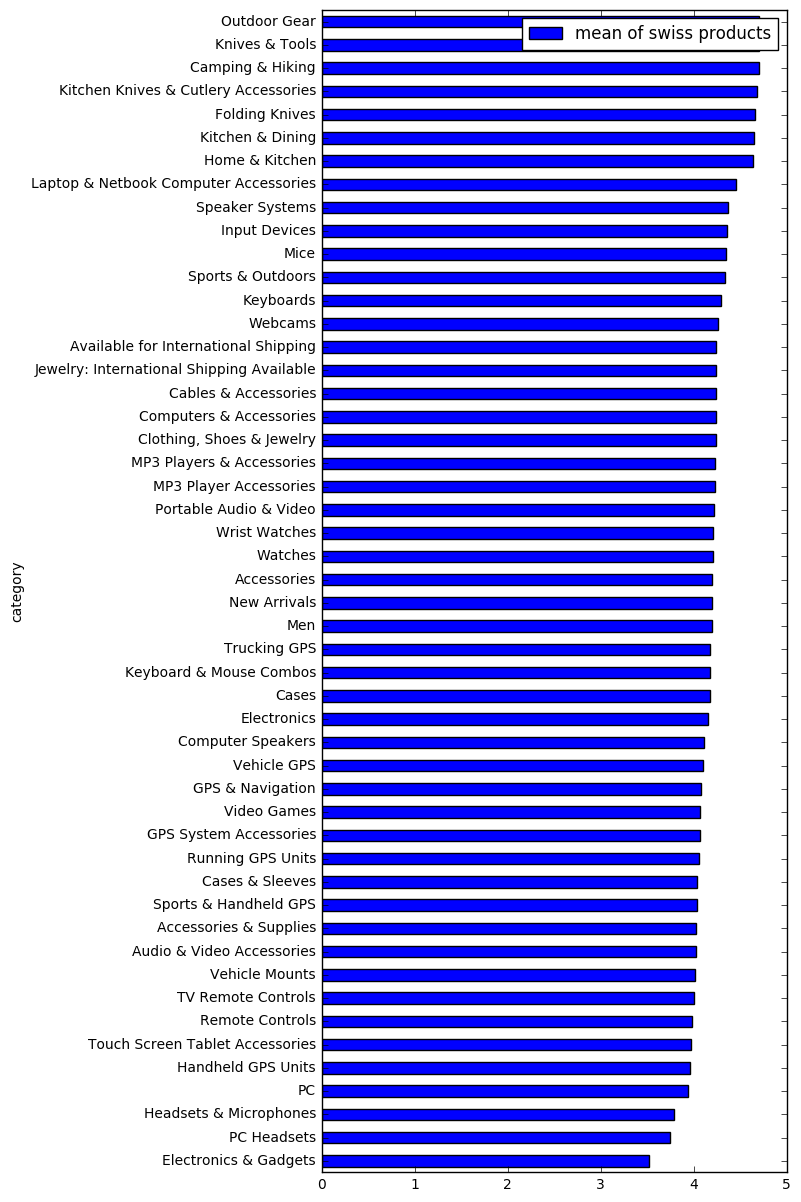

In [79]:
res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(6,15))

In [ ]:
RandomDF = transformCategories(RandomDF)
GermanDF = transformCategories(GermanDF)
FrenchDF = transformCategories(FrenchDF)
USDF = transformCategories(USDF)

/Users/bojan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bojan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
flat = RandomDF.categories.apply(lambda x: ' '.join(x)).str
resRandom = categoriesCount.keys().to_series().map(lambda c: RandomDF[flat.contains(c)].overall.mean())

flat = FrenchDF.categories.apply(lambda x: ' '.join(x)).str
resFrench = categoriesCount.keys().to_series().map(lambda c: FrenchDF[flat.contains(c)].overall.mean())

flat = GermanDF.categories.apply(lambda x: ' '.join(x)).str
resGerman= categoriesCount.keys().to_series().map(lambda c: GermanDF[flat.contains(c)].overall.mean())

flat = USDF.categories.apply(lambda x: ' '.join(x)).str
resUS = categoriesCount.keys().to_series().map(lambda c: USDF[flat.contains(c)].overall.mean())

In [ ]:
res['mean of random sample'] = resRandom
res['mean of french products'] = resFrench # maybe remove the french, there are too few reviews so it's misleading
res['mean of german products'] = resGerman
res['mean of US products'] = resUS

In [ ]:
res.head()

In [ ]:
res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(10,20))